<a href="https://colab.research.google.com/github/tomagnesium/NatureEMoi/blob/main/YouTube_phonetics_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

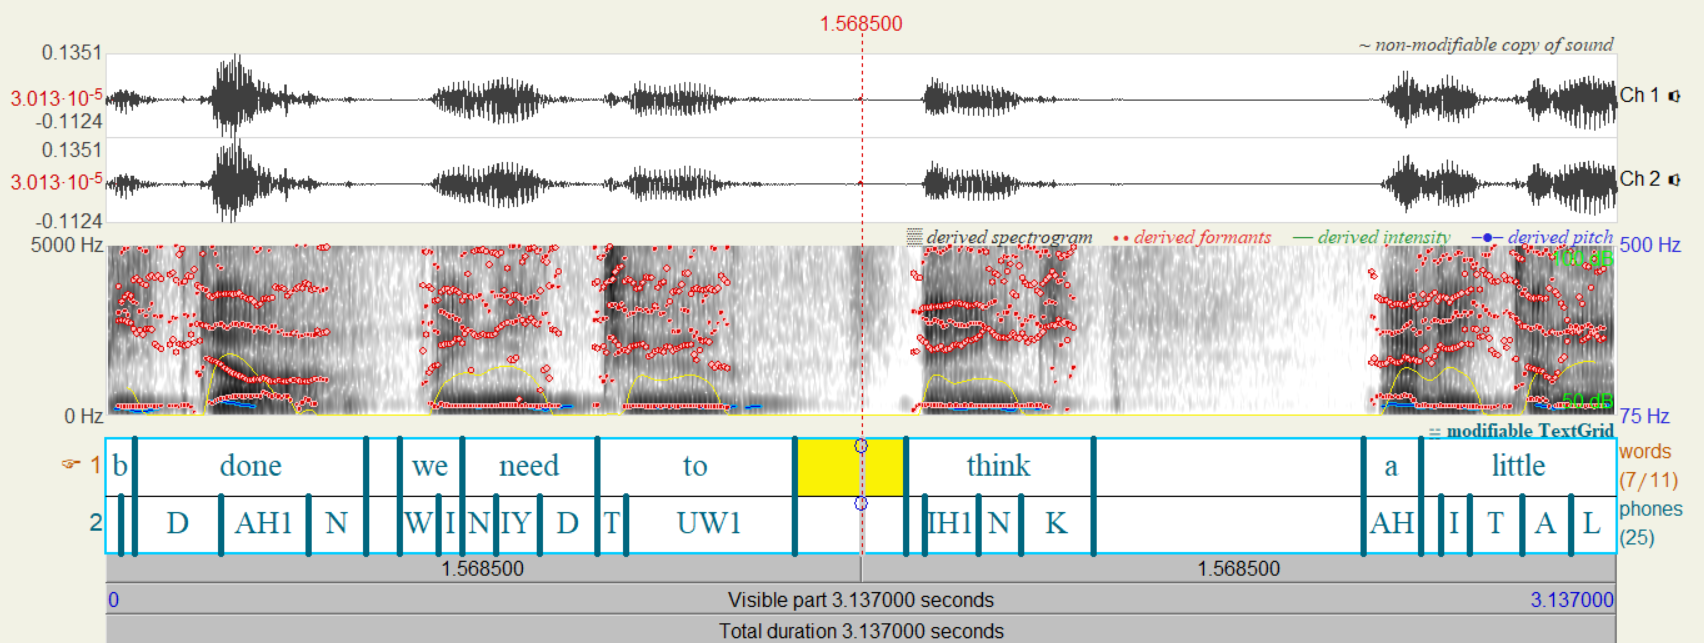

**Step 1: Install dependencies and import**

In [55]:
import os

if not os.path.exists('/content/phonetics_pipeline'):
  os.mkdir('/content/phonetics_pipeline')

%cd /content/phonetics_pipeline/

!pip install -U praat-parselmouth
!pip install -U pydub
!pip install -U yt-dlp
!pip install -U static-ffmpeg
!pip install -U webvtt-py
!pip install -U colab-xterm
!pip install -U praat-textgrids
!pip install -U adjustText

/content/phonetics_pipeline


In [56]:
import parselmouth
import pandas as pd
from parselmouth.praat import call
from pydub import AudioSegment
import glob
import yt_dlp
from yt_dlp.utils import download_range_func
import pickle
import requests
import os
import re
import numpy as np
import pathlib
import static_ffmpeg
import webvtt
import glob
import html
import spacy
nlp = spacy.load("en_core_web_sm")

**Step 2: Get ASR transcripts from a YT channel**

In [57]:
#Click on the stop button to end the downloading, otherwise it will attempt to retrieve all the transcripts in the channel

for x in ["https://www.youtube.com/watch?v=_P7_69FeqnU"]:    #This is the channel of Gallatin, Tennessee, USA.
# The script will try to get all of the videos with ASR transcripts in the channel (~740, as of May 2023)
# The list can contain multiple channels
# A list of single videos just needs the video IDs, for example ["GQFF4lD7rgk","-p9GfpbY-DY"]

        ydl_opts = {
                 'writeautomaticsub': True, #This will retrieve the YT-generated Automatic Speech Recognition transcript (not manual transcripts/captions)
                'subtitlelangs':'.en\-orig', #This retrieves only English-language transcripts and prevents download of transcripts automatically translated into English from another language
                'outtmpl': '/content/phonetics_pipeline/%(uploader)s/%(upload_date)s--%(id)s--%(title)s.%(ext)s', #Here we are using yt-dl syntax to capture the channel name, upload date, video id, video title, and file extension
                'skip_download':True,
                'ignoreerrors': True,
                'sleep_interval':4,
            }

        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                        try:
                            items = ydl.extract_info(x)
                        except:
                            continue

[youtube] Extracting URL: https://www.youtube.com/watch?v=_P7_69FeqnU
[youtube] _P7_69FeqnU: Downloading webpage
[youtube] _P7_69FeqnU: Downloading ios player API JSON
[youtube] _P7_69FeqnU: Downloading mweb player API JSON
[youtube] _P7_69FeqnU: Downloading m3u8 information
[info] _P7_69FeqnU: Downloading subtitles: en
[info] _P7_69FeqnU: Downloading 1 format(s): 399+251
[info] Writing video subtitles to: /content/phonetics_pipeline/Pronunciation with Emma/20210611--_P7_69FeqnU--Sentence Stress and Intonation in English (The Complete Guide).en.vtt
[download] Destination: /content/phonetics_pipeline/Pronunciation with Emma/20210611--_P7_69FeqnU--Sentence Stress and Intonation in English (The Complete Guide).en.vtt
[download] 100% of  109.18KiB in 00:00:00 at 1.55MiB/s


**Step 3: Functions to convert the ASR transcripts to standard text or to text with timing information on each token**

In [58]:
#Caption getter: The input is a single .vtt transcript file
#The output is a string containing the text of the transcript

def remove_adjacent(nums):
     return [a for a,b in zip(nums, nums[1:]+[not nums[-1]]) if a != b]

def get_sec(time_str):
    h, m, s = time_str.split(':')
    return round(int(h) * 3600 + int(m) * 60 + float(s),2)

def caption_getter(vid):
    items = vid.split("/")[3:]
    channel_name = items[0]
    names = items[-1].split("--")
    upload_date = names[0]
    video_title = names[2].replace(".en.vtt","").replace(".en-orig.vtt","")
    video_id = names[1]
    stripped1=[]
    captions = webvtt.read(vid)
    ends = []
    for caption in captions:
        ends.append(caption.end)
        stripped = caption.text.replace('\n', "\n")
        stripped1.append(stripped.split("\n"))
        text_transcript = [x for y in stripped1 for x in y if x != " "]
        text_transcript1 = " ".join(remove_adjacent(text_transcript))
        #caption1 = re.sub("\n","",caption.text).strip()
    return channel_name, video_id,video_title,upload_date,max([get_sec(x) for x in ends]),text_transcript1

In [59]:
#Timed caption getter: The input is a single .vtt transcript file
#The output is a string containing the text of the transcript with timing information attached to each token with the form token_123.45
#Tokens can also include a PoS tag (token_POS_123.45)
#See the comments in the code below

def get_sec(time_str):
    h, m, s = time_str.split(':')
    return round(int(h) * 3600 + int(m) * 60 + float(s),2)

def timed_caption_getter(vid):
    items = vid.split("/")[3:]
    channel_name = items[0]
    names = items[-1].split("--")
    upload_date = names[0]
    video_title = names[2].replace(".en.vtt","").replace(".en-orig.vtt","")
    video_id = names[1]
    captions = webvtt.read(vid)
    ends = []
    text_transcript = []
    for caption in captions:
        ends.append(caption.end)
        caption_unescaped= html.unescape(caption.start+caption.raw_text+caption.end)
        text_transcript.extend(re.findall("(<?\s?\d\d\:\d\d\:\d\d\.\d\d\d>?)?([\[\w+](?:[\w'-\.\&\%]+?)?[^\<]?)?(?:<?/c.*?>){0,3}(<?\s?\d\d\:\d\d\:\d\d\.\d\d\d>?)",caption_unescaped))
    tt = [x for x in text_transcript if x[1] != "" and not "\n" in x[1]]
    text_timed_transcript = " ".join([v[1]+"_"+str(get_sec(v[2].replace("<","").replace(">",""))) for v in tt])
    return channel_name, video_id,video_title,upload_date,max([get_sec(x) for x in ends]),text_timed_transcript


    #To add the PoS tags, comment out the two lines immediately above and uncomment the lines below!

    #nlp = spacy.load("en_core_web_sm")
    #doc = spacy.tokens.doc.Doc(nlp.vocab, words=[x[1] for x in tt])
    #for name, proc in nlp.pipeline:
    #    doc = proc(doc)
    #tags = [z.tag_ for z in doc]
    #text_timedpos_transcript = " ".join([v[1]+"_"+tags[i]+"_"+str(get_sec(v[2].replace("<","").replace(">",""))) for i,v in enumerate(tt)])
    #return channel_name, video_id,video_title,upload_date,max([get_sec(x) for x in ends]),text_timedpos_transcript

**Step 4: Make a data frame from the transcripts**

In [60]:
#If you are only interested in the text of the transcript, and not the timing information, use the caption_getter function instead of timed_caption_getter

vids = glob.glob("/content/phonetics_pipeline/Pronunciation with Emma/*.vtt")
vids_list = []
for y in vids:
  vids_list.append(timed_caption_getter(y))

vids_df = pd.DataFrame(vids_list)
vids_df.columns = ["channel_name", "video_id","video_title","upload_date", "video_length","text"]
vids_df

,channel_name,video_id,video_title,upload_date,video_length,text
0,Pronunciation with Emma,_P7_69FeqnU,Sentence Stress and Intonation in English (The...,20210611,837.67,[Music]_3.76 hello_4.16 and_4.32 welcome_4.64 ...


**Step 5: Get the audio for items of interest in the transcripts**

In [61]:
#This step downloads the targeted audio and transcript segments
#In this example we are retrieving all instances of "need to" in our small corpus, plus three words to the left and right of the target
#This version works with a data frame in which tokens have the form token_1.00. For a frame where tokens have the form token_POS_1.00, see the comment below

hits = []
for i,x in vids_df.iterrows():
    target = re.compile(r"((\w+_\S+\s){4}need_\S+\s+to_\S+\s+(\w+_\S+\s){3})",re.IGNORECASE)
    #For a larger "window", change the {4} and {3} tokens before and after to a higher number
    #For entries in which the text has the format word_POS_1.00, use:
    #target = re.compile(r"((\w+_\w+_\S+\s){4}need_\w+_\S+\s+to_\w+_\S+\s+(\w+_\w+_\S+\s){3})",re.IGNORECASE)

    if target.search(x["text"]):
        finds1 = target.findall(x["text"])
        for i,y in enumerate(finds1):
            seq = " ".join([z.split("_")[0] for z in y[0].split()][1:])
            time1 = float(y[0].split()[0].split("_")[-1])
            time2 = float(y[0].split()[-1].split("_")[-1])
            time_dif = float(time2)-float(time1)
            if time_dif < 7:  #to prevent downloading segments with long pauses
                pathlib.Path('/content/phonetics_pipeline/'+x["channel_name"]+'/audio').mkdir(parents=True, exist_ok=True)
                with open('/content/phonetics_pipeline/'+x["channel_name"]+'/audio/'+x["video_id"]+'_'+str(seq)+'_'+str(i)+'.txt','w+') as f:
                    f.write(seq)
                ydl_opts = {'format':'ba[ext=m4a]/ba[ext=mp4]','overwrites' : True,'extract-audio':True,
                #To retrieve video fragments instead of audio fragments, comment out the line above and uncomment the line below
                #ydl_opts =  {'format':'bv*[ext=mp4]+ba[ext=m4a]/b[ext=mp4]/bv*+ba/b','overwrites' : True,'extract-audio':True,
                            'outtmpl': '/content/phonetics_pipeline/'+x["channel_name"]+'/audio/'+x["video_id"]+'_'+str(seq)+'_'+str(i)+'.mp4',
                            'download_ranges': download_range_func([], [(time1, time2)]),
                            'quiet':True}
                with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                    try:
                        ydl.download('https://www.youtube.com/watch?v='+x["video_id"])
                    except yt_dlp.utils.DownloadError:
                        print("An exception has been caught")
            else:
                pass

In [62]:
#We convert the .mp4 files to 16k Hz .wav for the Montreal Forced Aligner

sounds = glob.glob("/content/phonetics_pipeline/CityofGallatin/audio/*.mp4")
for y in sounds:
  wav_audio = AudioSegment.from_file(y, format="mp4")
  wav_audio = wav_audio.set_frame_rate(16000)  #This is what MFA/Kaldi expects
  wav_audio = wav_audio.set_sample_width(2)  #2 byte = 16 bit
  wav_audio.export(y.replace(".mp4",".wav"), format="wav")
  os.remove(y)

**Step 6: Install the Montreal Forced Aligner**

In [63]:
#mfa
# from https://colab.research.google.com/gist/NTT123/12264d15afad861cb897f7a20a01762e/mfa-ljspeech.ipynb

%%writefile install_mfa.sh
#!/bin/bash

## a script to install Montreal Forced Aligner (MFA)

root_dir=${1:-/tmp/mfa}
mkdir -p $root_dir
cd $root_dir

# download miniconda3
wget -q --show-progress https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh -b -p $root_dir/miniconda3 -f

#install MFA
$root_dir/miniconda3/bin/conda create -n aligner -c conda-forge montreal-forced-aligner# scikit-learn=1.2.2 -y #scikit-learn >= 1.3 has a new hdbscan which breaks MFA, as of July 2023

echo -e "\n======== DONE =========="
echo -e "\nTo activate MFA, run: source $root_dir/miniconda3/bin/activate aligner"
echo -e "\nTo delete MFA, run: rm -rf $root_dir"
echo -e "\nSee: https://montreal-forced-aligner.readthedocs.io/en/latest/aligning.html to know how to use MFA"

Writing install_mfa.sh


In [64]:
# download and install mfa
INSTALL_DIR="/tmp/mfa" # path to install directory

!bash ./install_mfa.sh {INSTALL_DIR}
!source {INSTALL_DIR}/miniconda3/bin/activate aligner; mfa align --help

Miniconda3-latest-L 100%[===================>] 140.94M   168MB/s    in 0.8s    
PREFIX=/tmp/mfa/miniconda3
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /tmp/mfa/miniconda3
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: | / - \ | done

## Package Plan ##

  environment location: /tmp/mfa/miniconda3/envs/aligner

  added / updated specs:
    - montreal-forced-aligner
    - scikit-learn=1.2.2


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge 
  _openm

In [65]:
# download a pretrained English acoustic model and English lexicon
!wget -q --show-progress https://github.com/MontrealCorpusTools/mfa-models/raw/main/acoustic/english.zip
!wget -q --show-progress https://github.com/MontrealCorpusTools/mfa-models/raw/main/dictionary/english/us_arpa/english_us_arpa.dict
#These are other dictionaries/models to try:
#!wget -q --show-progress https://github.com/MontrealCorpusTools/mfa-models/releases/download/acoustic-english_mfa-v2.2.1/english_mfa.zip
#!wget -q --show-progress https://github.com/MontrealCorpusTools/mfa-models/releases/download/dictionary-english_mfa-v2.2.1/english_mfa.dict

english.zip         100%[===================>]  14.05M  --.-KB/s    in 0.1s    
english_us_arpa.dic 100%[===================>]   5.35M  --.-KB/s    in 0.09s   


In [66]:
# Make a directory for the aligned TextGrid files
os.mkdir("/content/phonetics_pipeline/Pronunciation with Emma/audio/aligned")

**Step 7: Align the transcript excerpts with the audio excerpts**

In [67]:
!source /tmp/mfa/miniconda3/bin/activate aligner; mfa align --clean /content/phonetics_pipeline /content/phonetics_pipeline/english_us_arpa.dict  /content/phonetics_pipeline/english.zip /content/phonetics_pipeline/Pronunciation with Emma/audio/aligned


 INFO     Setting up corpus information...                                                          
 INFO     Loading corpus from source files...                                                       
   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/100  [ 0:00:01 < -:--:-- , ? it/s ]
 ERROR    There was an error in the run, please see the log.                                        
Exception ignored in atexit callback: <bound method ExitHooks.history_save_handler of <montreal_forced_aligner.command_line.mfa.ExitHooks object at 0x7bf6f82f3990>>
Traceback (most recent call last):
  File "/tmp/mfa/miniconda3/envs/aligner/lib/python3.11/site-packages/montreal_forced_aligner/command_line/mfa.py", line 110, in history_save_handler
    raise self.exception
  File "/tmp/mfa/miniconda3/envs/aligner/bin/mfa", line 10, in <module>
    sys.exit(mfa_cli())
             ^^^^^^^^^
  File "/tmp/mfa/miniconda3/envs/aligner/lib/python3.11/site-packages/rich_click/rich_command.py", lin

In [68]:
#Now you should have the aligned TextGrids
import textgrids

**Step 8: Get F1 and F2 formant values for the vowels**

In [69]:
grids = glob.glob("/content/phonetics_pipeline/Pronunciation with Emma/audio/aligned/*.TextGrid")
frame = []

for y in grids:
        sound = "/content/phonetics_pipeline/Pronunciation with Emma/audio/"+y.split("/")[-1].replace(".TextGrid",".wav")
        grid = textgrids.TextGrid(y)
        words = grid.interval_tier_to_array("words")
        phones = grid.interval_tier_to_array("phones")
        #state, channel, file = [y.split("/")[i] for i in [5,6,9]]
        channel, file = [y.split("/")[i] for i in [3,6]]
        filename = file.replace(".TextGrid",".wav")
        for j, x in enumerate(words):
            for z in phones:
                if  x["begin"] <= z["begin"] < x["end"]:
                    if z["label"].startswith(("A","E","I","O","U","Y")):
                        xmin=z["begin"]#float([x.xmin for x in grid["phones"]][0])
                        xmax =z["end"]#float([x.xmax for x in grid["phones"]][0])
                        dur = round(float(xmax)-float(xmin),3)
                        sn = parselmouth.Sound(sound)
                        vw = sn.extract_part(xmin,xmax)
                        formants = call(vw, "To Formant (burg)", 0.0025, 5, 5000, 0.025, 50)
                        for i in np.linspace(0,vw.xmax,11): #change this get fewer or more measurements per vowel
                            f1 = call(formants, "Get value at time", 1, i, 'Hertz', 'Linear')
                            f2 = call(formants, "Get value at time", 2, i, 'Hertz', 'Linear')
                            frame.append([channel,filename,j,x["label"],z["label"],
                                          dur,round(i/vw.xmax,1),f1,f2])

vowels_df = pd.DataFrame(frame)
vowels_df.columns = ["channel","file","wordnr","word","vowel","dur","pct","f1","f2"]
vowels_df1 = vowels_df[vowels_df["f1"].notnull()].reset_index(drop=True)
vowels_df1



ValueError: Length mismatch: Expected axis has 0 elements, new values have 9 elements

In [ ]:
#Map the phonemes of the ARPA dictionary to IPA

arpa2ipa = {'AO' : 'ɔ',
'AO0' : 'ɔ',
'AO1' : 'ɔ',
'AO2' : 'ɔ',
'AA' : 'ɑ',
'AA0' : 'ɑ',
'AA1' : 'ɑ',
'AA2' : 'ɑ',
'IY' : 'i',
'IY0' : 'i',
'IY1' : 'i',
'IY2' : 'i',
'UW' : 'u',
'UW0' : 'u',
'UW1' : 'u',
'UW2' : 'u',
'EH' : 'ɛ',
'EH0' : 'ɛ',
'EH1' : 'ɛ',
'EH2' : 'ɛ',
'IH' : 'ɪ',
'IH0' : 'ɪ',
'IH1' : 'ɪ',
'IH2' : 'ɪ',
'UH' : 'ʊ',
'UH0' : 'ʊ',
'UH1' : 'ʊ',
'UH2' : 'ʊ',
'AH' : 'ʌ',
'AH0' : 'ə',
'AH1' : 'ʌ',
'AH2' : 'ʌ',
'AE' : 'æ',
'AE0' : 'æ',
'AE1' : 'æ',
'AE2' : 'æ',
'AX' : 'ə',
'AX0' : 'ə',
'AX1' : 'ə',
'AX2' : 'ə',
#/*
#Vowels - Diphthongs
#ArpabetIPAWord Examples
#EYeɪsay (S EY1); eight (EY1 T)
#AYaɪmy (M AY1); why (W AY1); ride (R AY1 D)
#OWoʊshow (SH OW1); coat (K OW1 T)
#AWaʊhow (HH AW1); now (N AW1)
#OYɔɪboy (B OY1); toy (T OY1)
#*/
'EY' : 'eɪ',
'EY0' : 'eɪ',
'EY1' : 'eɪ',
'EY2' : 'eɪ',
'AY' : 'aɪ',
'AY0' : 'aɪ',
'AY1' : 'aɪ',
'AY2' : 'aɪ',
'OW' : 'oʊ',
'OW0' : 'oʊ',
'OW1' : 'oʊ',
'OW2' : 'oʊ',
'AW' : 'aʊ',
'AW0' : 'aʊ',
'AW1' : 'aʊ',
'AW2' : 'aʊ',
'OY' : 'ɔɪ',
'OY0' : 'ɔɪ',
'OY1' : 'ɔɪ',
'OY2' : 'ɔɪ',
'Y'   : 'y',
#/*
#Consonants - Stops
#ArpabetIPAWord Examples
#Pppay (P EY1)
#Bbbuy (B AY1)
#Tttake (T EY1 K)
#Ddday (D EY1)
#Kkkey (K IY1)
#Gɡgo (G OW1)
#*/
'P' : 'p',
'B' : 'b',
'T' : 't',
'D' : 'd',
'K' : 'k',
'G' : 'g',
#/*
#Consonants - Affricates
#ArpabetIPAWord Examples
#CHtʃchair (CH EH1 R)
#JHdʒjust (JH AH1 S T); gym (JH IH1 M)
#*/
'CH' : 'tʃ',
'JH' : 'dʒ',

#/*
#Consonants - Fricatives
#ArpabetIPAWord Examples
#Fffor (F AO1 R)
#Vvvery (V EH1 R IY0)
#THθthanks (TH AE1 NG K S); Thursday (TH ER1 Z D EY2)
#DHðthat (DH AE1 T); the (DH AH0); them (DH EH1 M)
#Sssay (S EY1)
#Zzzoo (Z UW1)
#SHʃshow (SH OW1)
#ZHʒmeasure (M EH1 ZH ER0); pleasure (P L EH1 ZH ER)
#HHhhouse (HH AW1 S)
#*/
'F' : 'f',
'V' : 'v',
'TH' : 'θ',
'DH' : 'ð',
'S' : 's',
'Z' : 'z',
'SH' : 'ʃ',
'ZH' : 'ʒ',
'HH' : 'h',
#/*
#Consonants - Nasals
#ArpabetIPAWord Examples
#Mmman (M AE1 N)
#Nnno (N OW1)
#NGŋsing (S IH1 NG)
#*/
'M' : 'm',
'N' : 'n',
'NG' : 'ŋ',

#/*
# Consonants - Liquids
#ArpabetIPAWord Examples
#Lɫ OR llate (L EY1 T)
#Rr OR ɹrun (R AH1 N)
#*/
'L' : 'l',
'R' : 'r',

#Vowels - R-colored vowels
#ArpabetIPAWord Examples
#ERɝher (HH ER0); bird (B ER1 D); hurt (HH ER1 T), nurse (N ER1 S)
#AXRɚfather (F AA1 DH ER); coward (K AW1 ER D)
#The following R-colored vowels are contemplated above
#EH Rɛrair (EH1 R); where (W EH1 R); hair (HH EH1 R)
##H Rʊrcure (K Y UH1 R); bureau (B Y UH1 R OW0), detour (D IH0 T UH1 R)
#AO Rɔrmore (M AO1 R); bored (B AO1 R D); chord (K AO1 R D)
#AA Rɑrlarge (L AA1 R JH); hard (HH AA1 R D)
#IH R or IY Rɪrear (IY1 R); near (N IH1 R)
#AW RaʊrThis seems to be a rarely used r-controlled vowel. In some dialects flower (F L AW1 R; in other dialects F L AW1 ER0)

'ER' : 'ɜr',
'ER0' : 'ɜr',
'ER1' : 'ɜr',
'ER2' : 'ɜr',
'AXR' : 'ər',
'AXR0' : 'ər',
'AXR1' : 'ər',
'AXR2' : 'ər'}

**Step 9: Plot the average F1/F2 values for the vowels in the data**

In [ ]:
#Set up a plot for values in formant space

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pathlib
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev, BSpline, make_interp_spline, InterpolatedUnivariateSpline


def garnish(ax):
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()
    ax.set_xlabel('F2')
    ax.set_ylabel('F1')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('right')
    ax.set_xlim(2500, 750)
    ax.set_ylim(900, 200)
    return ax

In [ ]:
#This plots the mean values for monophthongs in F1/F2 space. The annotations indicate the number of tokens and measurements per vowel

import matplotlib.cm as cm
import seaborn as sns
sns.set_theme()
from adjustText import adjust_text
from matplotlib import pyplot as plt

from itertools import cycle
fz = []
#colors = cycle(['red', 'yellow', 'green','blue','pink','brown','orange'])
fig, ax = plt.subplots(figsize=(8,8))
texts = []
ax = garnish(ax)
df = vowels_df1
for x in ['IY1','UH1',  'IH1', 'AE1', 'EH1',
        'UW1', 'AO1', 'AH1',  'AA1',
         'ER1']:
        #'AY1', 'EY1', 'AW1','OW1',]:

    if len(df[df["vowel"]==x].file.unique()) > 0:
                            vowels = len(df[df["vowel"]==x].groupby(["file","wordnr"]).size())
                            msmts = len(df[df["vowel"]==x])
                            pts = np.vstack((df[df["vowel"]==x].groupby("pct")["f2"].mean().values,
                                              df[df["vowel"]==x].groupby("pct")["f1"].mean().values))
                            try:
                                #The following lines are to map formant trajectories (for example of diphthongs)
                                #tck, u = splprep(pts, s=10,k = 2)
                                #u_new = np.linspace(u.min(), u.max(), 1000)
                                #x_new, y_new = splev(u_new, tck)
                                #ax.plot(x_new, y_new, '--')
                                #ax.plot(dg.f2, dg.f1)
                                #ax.scatter(dg.f2.dropna(), dg.f1.dropna(),
                                #        zorder=1 )
                                #s = InterpolatedUnivariateSpline(dg1.f2.dropna(), dg1.f1.dropna())
                                #xfit = np.arange(dg1.f2.dropna().min(), dg1.f2.dropna().max(), .0003)
                                #yfit = s(xfit)
                                #ax.plot(xfit, yfit)# 'g')#, lw=3, color="red")

                                ax.scatter(df[df["vowel"]==x].groupby("pct")["f2"].mean().values.mean(),
                                                  df[df["vowel"]==x].groupby("pct")["f1"].mean().values.mean(),
                                           s=msmts*10, alpha = .5,
                                        zorder=1 )
                                texts.append(ax.text(df[df["vowel"]==x].groupby("pct")["f2"].mean().values.mean(),
                                        df[df["vowel"]==x].groupby("pct")["f1"].mean().values.mean(),

                                        arpa2ipa[x]+", "+str(vowels)+", "+str(msmts),
                                        fontdict={'fontsize': 8, 'fontweight': 'medium'}))

                            except:
                                continue
adjust_text(texts)
plt.show(block=False)


**Step 10: Plot the intensity and the spectrogram with the words and phones**

In [ ]:
#Pseudo-Praat-style visualization

for x in grids[5:8]:
  g1 = textgrids.TextGrid(x)
  words = g1.interval_tier_to_array("words")
  phones = g1.interval_tier_to_array("phones")
  sound = "/content/phonetics_pipeline/CityofGallatin/audio/"+x.split("/")[-1].replace(".TextGrid",".wav")
  snd = parselmouth.Sound(sound)
  spectrogram = snd.to_spectrogram()
  intensity = snd.to_intensity()
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(15, 8), height_ratios=[3,3,1,1])
  X, Y = spectrogram.x_grid(), spectrogram.y_grid()
  sg_db = 10 * np.log10(spectrogram.values)
  ax1.plot(snd.xs(), snd.values.T)
  ax1.set_ylabel("intensity")
  ax2.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - 70, cmap='binary')
  #ax2.plot(x + 1, -y)
  ax2.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
  ax2.plot(intensity.xs(), intensity.values.T, linewidth=1)
  ax2.set_ylabel("frequency [Hz]")
  for x in words:
      ax3.axvline(x=x["begin"])
      ax3.axvline(x=x["end"])
      ax3.text(x["begin"]+((x["end"]-x["begin"])/2), 0.5, x["label"],
              horizontalalignment='center',
              fontsize=9)
      ax3.yaxis.set_visible(False)
  for x in phones:
      ax4.axvline(x=x["begin"])
      ax4.axvline(x=x["end"])
      ax4.text(x["begin"]+((x["end"]-x["begin"])/2), 0.5, x["label"],
              horizontalalignment='center',
              fontsize=9)
      ax4.yaxis.set_visible(False)
  plt.subplots_adjust(wspace=0, hspace=0)
